In [1]:
# Select GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
images = np.vstack([train_images, test_images])
labels = np.hstack([train_labels, test_labels])
assert len(images) == len(labels)
images.shape, labels.shape

((70000, 28, 28), (70000,))

In [6]:
images = images.reshape(images.shape[0], 28, 28, 1).astype('float32')
images = (images - 127.5) / 127.5

In [7]:
BUFFER_SIZE = 70000
BATCH_SIZE = 256
assert BUFFER_SIZE == len(images)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
NOISE_SHAPE = 100

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(NOISE_SHAPE,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

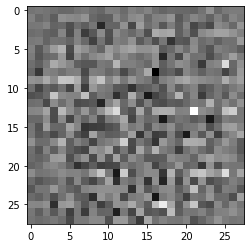

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [12]:
def make_discriminator_model():
    with tf.name_scope('discriminator'):
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Flatten())
        model.add(layers.Dense(1)) # how real is the image?
    
    return model

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00268255]], dtype=float32)>

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    # output = decision
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
EPOCHS = 500
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, NOISE_SHAPE])

In [20]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_SHAPE])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    grads_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grads_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # with a fixed discriminator, make the generator optimize for trying to convince D that image is real
    generator_optimizer.apply_gradients(zip(grads_of_generator, generator.trainable_variables))
    
    # with a fixed generator, make generated images less beliavable than true images
    discriminator_optimizer.apply_gradients(zip(grads_of_disc, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [21]:
def train(dataset, epochs, checkpoint_interval=15):
    
    all_gen_losses = []
    all_disc_losses = []
    
    for epoch in range(epochs):
        
        start = time.time()
        
        avg_gen_loss = []
        avg_disc_loss = []
        
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            avg_gen_loss.append(gen_loss)
            avg_disc_loss.append(disc_loss)
            
        display.clear_output(wait=True)
        
        avg_gen_loss = np.mean(avg_gen_loss)
        avg_disc_loss = np.mean(avg_disc_loss)
        
        print("Gen loss {} Disc loss {}".format(avg_gen_loss, avg_disc_loss))
        
        all_gen_losses.append(avg_gen_loss)
        all_disc_losses.append(avg_disc_loss)
            
        generate_and_save_images(generator, epoch + 1, seed)
        
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    
    return all_gen_losses, all_disc_losses

In [22]:
def generate_and_save_images(generator, epoch, noise):
    images = generator(noise, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')mm
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

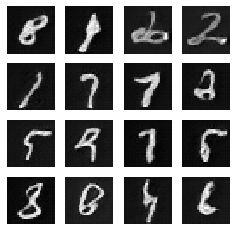

In [23]:
all_gen_losses, all_disc_losses = train(train_dataset, EPOCHS)

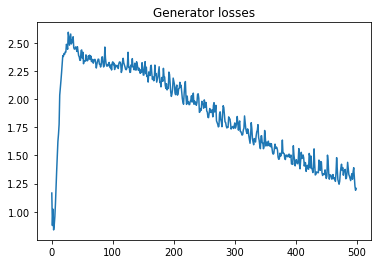

In [24]:
plt.figure()
plt.title("Generator losses")
plt.plot(all_gen_losses)
plt.show()

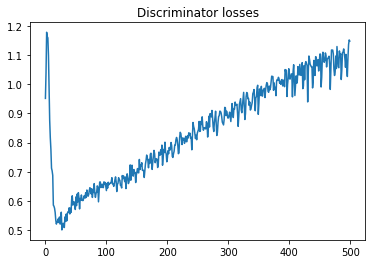

In [25]:
plt.figure()
plt.title("Discriminator losses")
plt.plot(all_disc_losses)
plt.show()

In [26]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [27]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

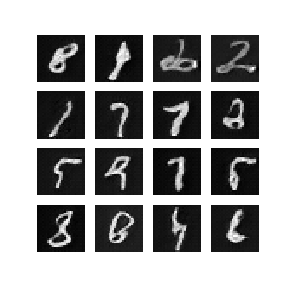

In [28]:
display_image(EPOCHS)

In [29]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filename = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5) # ??? making them fast at the beginning?
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

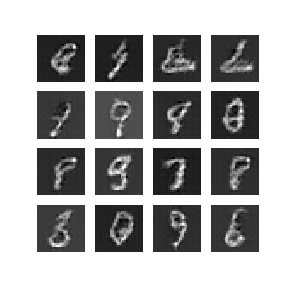

In [30]:
import IPython
display.Image(filename=anim_file)